In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing as sk_pre
import sklearn.decomposition as sk_dec
import sklearn.model_selection as sk_mos
import sklearn.neural_network as sk_nn
import yaml
import networkx as nx
import re

from dataclasses import dataclass

In [48]:
maestro_data = pd.read_csv("../data/maestro-calculated.csv", low_memory=False)
maestro_data = maestro_data[(maestro_data["workflow_name"] == "securitization-flow")]

In [49]:
jobs = maestro_data["job_name"].unique()
business_day = maestro_data["business-day"].unique()

run-lvr-securitization, has no entries for BD == BD0
run-lvr-securitization, has no entries for BD == BD2
run-lvr-securitization, has no entries for BD == BD3
run-lvr-securitization, has no entries for BD == BD4
reload-securitization-tables-lvr, has no entries for BD == BD0
reload-securitization-tables-lvr, has no entries for BD == BD2
reload-securitization-tables-lvr, has no entries for BD == BD3
reload-securitization-tables-lvr, has no entries for BD == BD4


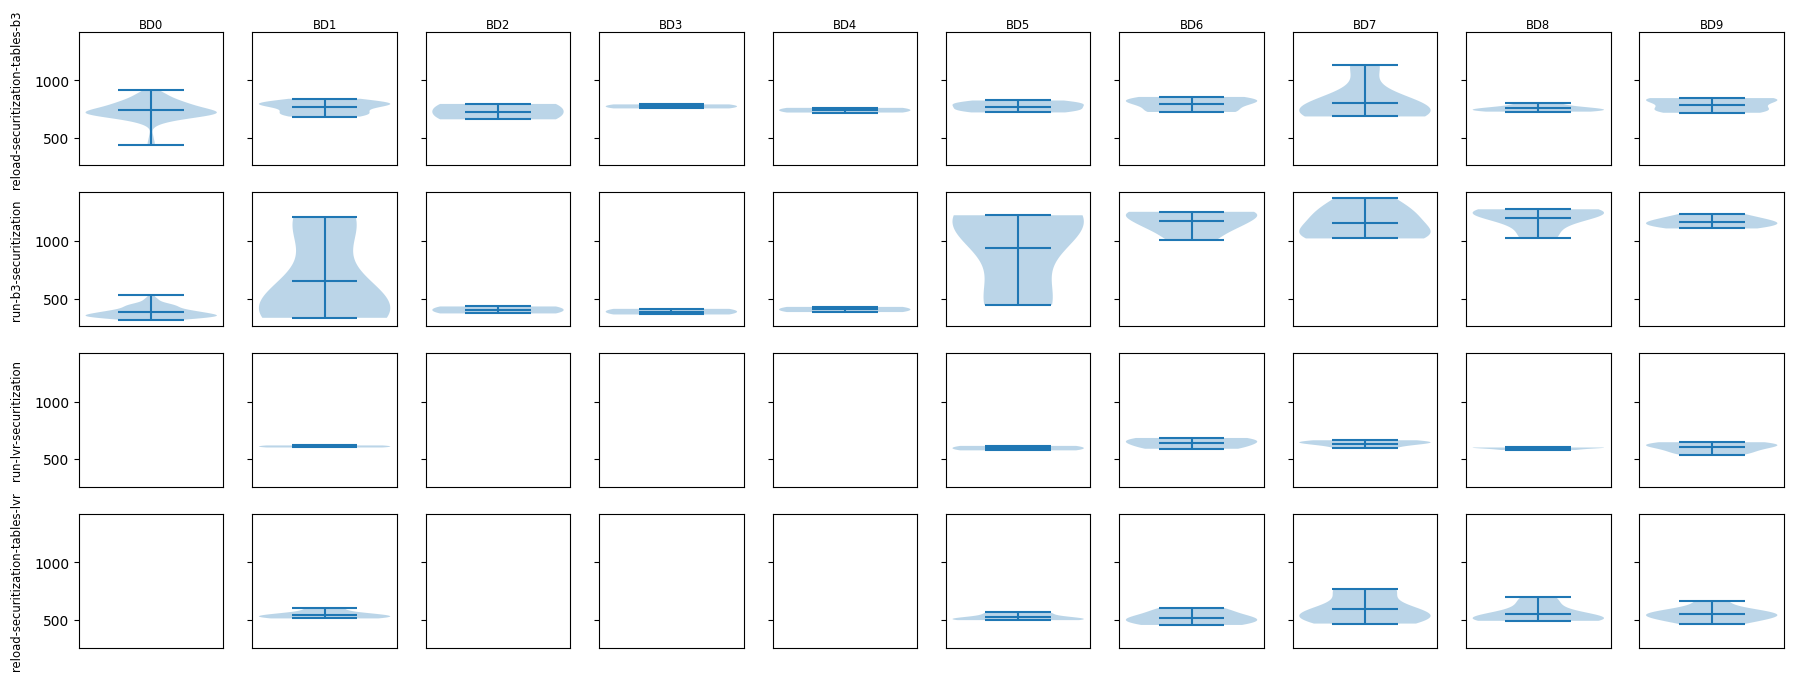

In [50]:
tasks = [6, 4, 17, 19]
COLUMN_NAME = "event-processing-time"

fig, ax = plt.subplots(len(tasks), 10, figsize=(2*len(business_day), 2*len(tasks)), sharey=True, sharex=True)
for j, task in enumerate(tasks):
    job = jobs[task]
    for i, bd in enumerate([f"BD{i}" for i in range(10)]):
        ax[j, i].xaxis.set_visible(False)
        arr = maestro_data.filter(like=COLUMN_NAME)[(maestro_data["job_name"] == job) & (maestro_data["business-day"] == bd)]
        nparr = arr.to_numpy()
        try:
            q01, q99 = np.quantile(nparr, 0.05), np.quantile(nparr, 0.95)
            ax[j, i].violinplot(arr[(q01 <= arr[COLUMN_NAME]) & (arr[COLUMN_NAME] <= q99)], range(1), showmeans=True)
        except:
            print(f"{job}, has no entries for BD == {bd}")

for ax_, row in zip(ax[:, 0], tasks):
    ax_.annotate(jobs[row], 
        xy=(0, 0.5), xytext=(-ax_.yaxis.labelpad, 0),
        xycoords=ax_.yaxis.label, textcoords='offset points',
        size='small', ha='right', va='center',
        rotation=90.0
    )

for ax_, col in zip(ax[0, :], range(10)):
    ax_.annotate(f"BD{col}",
        xy=(0.5, 1), xytext=(0, 5),
        xycoords="axes fraction", textcoords='offset points',
        size='small', ha='center', va='center',
    )

In [51]:
@dataclass(order=False)
class Job:
    q05: float
    q95: float
    mean: float
    len: float
    score: float
    job: str

    def __str__(self):
        return f"<q05={self.q05: 9.2f} q95={self.q95: 9.2f} mean={self.mean: 9.2f} len={self.len: 4d} score={self.score: 9.2f} job={self.job}>"
    
    def __hash__(self) -> int:
        return hash(str(self))

trainable_jobs = set()

# columns_label = {
#     "skip-mdl-out", "batch-workflow", "flow-type",
#     "rules-branch", "business-day", "batch-instance-seq", "ib-run-id",
#     "hac-run-id", "regulatory-approaches"
# }
columns_label = {
    'regulatory-approaches', 'ib-run-id', 'rules-branch',
    'processing-location-is-eur', 'event-total-time', 'skip-mdl-out', 'business_date',
    'setenv', 'bsinp-run-id', 'processing-location-is-sec',
    'processing-location-is-pac', 'rd-run-id', 'source-type-is-ib',
    'business-day', 'processing-location-is-ch', 'batch-instance-seq',
    'processing-location-is-ams', 'batch-workflow',
    'pb-run-id', 'source-type-is-pb', 'process-flag', 'flow-type',
    'hac-run-id', 'skip-mdl-landing'
}
# "event_success_time"
for job in jobs:
    labelizer = dict.fromkeys(columns_label, None)
    maestro_cut = maestro_data[list(columns_label) + ["event-processing-time"]][maestro_data["job_name"] == job].copy()
    maestro_times = maestro_cut.pop("event-processing-time").astype(float)

    q05, q95 = maestro_times.quantile(0.02), maestro_times.quantile(0.98)
    cut = maestro_times[(maestro_times >= q05) & (maestro_times <= q95)]
    mean = cut.mean()
    maestro_times /= mean
    if mean == 0:
        print(f'Skipping job: {job}, q05: {q05:.04}, q95: {q95:.04}, mean: {mean:.04}, len: {len(cut)}')
        continue

    for i, item in enumerate(list(columns_label)):
        labelizer[item] = sk_pre.LabelEncoder()
        labelizer[item].fit(list(set(maestro_cut[item])))
        maestro_cut[item] = labelizer[item].fit_transform(maestro_cut[item])

    x_train, x_test, y_train, y_test = sk_mos.train_test_split(maestro_cut, maestro_times)

    nn = sk_nn.MLPRegressor(max_iter=10_000, activation="logistic", batch_size=min(32, len(y_train)), hidden_layer_sizes=[100, 100])
    nn.fit(x_train, y_train)
    score = nn.score(x_test, y_test)
    trainable_jobs.add(Job(q05, q95, mean, len(cut), score, job))
    

Skipping job: skip-regional-batches, q05: 0.0, q95: 0.0, mean: 0.0, len: 148
Skipping job: complete-strategic-batch-sec, q05: 0.0, q95: 0.0, mean: 0.0, len: 151


In [52]:
for i in sorted(list(trainable_jobs), key=lambda a: a.mean, reverse=True):
    print(i)

<q05=   412.00 q95=  1203.00 mean=   747.16 len= 164 score=     0.42 job=reload-securitization-tables-b3>
<q05=   408.66 q95=  1184.68 mean=   719.38 len= 176 score=     0.53 job=reload-securitization-tables-b3std>
<q05=   533.96 q95=   935.94 mean=   628.03 len=  30 score=   -10.19 job=run-lvr-securitization>
<q05=   310.76 q95=  1383.16 mean=   596.77 len= 162 score=     0.94 job=run-b3-securitization>
<q05=    75.64 q95=  1072.04 mean=   589.58 len= 175 score=     0.68 job=reload-securitization-tables-lech>
<q05=   435.12 q95=  1152.40 mean=   550.95 len=  55 score=     0.02 job=reload-securitization-tables-lvr>
<q05=   262.88 q95=  1109.34 mean=   538.74 len= 176 score=     0.94 job=run-b3std-securitization>
<q05=   337.72 q95=   700.28 mean=   491.99 len= 160 score=     0.89 job=run-sec-tactical-staging>
<q05=   149.64 q95=  1267.80 mean=   478.28 len= 175 score=     0.93 job=run-lech-securitization>
<q05=    76.32 q95=   538.80 mean=   354.53 len=  55 score=     0.56 job=mdl-out-

In [53]:
# why colon is not in quote in yaml wtf
pattern = re.compile(r"^(\s+[\w-]+: )(.*:.*)$", re.MULTILINE)

with open("../data/strategic-flow.yml") as file:
    content = ""
    for line in file:
        if(match := pattern.match(line)):
            pre, missing_quote = match.groups()
            content += f'{pre}"{missing_quote}"\n'
        else:
            content += line

    securization_flow_yaml = yaml.load(content, yaml.Loader)

In [54]:
securization_flow = nx.DiGraph()
for job_pre in securization_flow_yaml["workflows"][0]["jobs"]:
    if (job := job_pre.get("job", None)):
        name = job.get("name", None)
        for precondition in job.get("precondition", []):
            securization_flow.add_edge(job.get("name"), precondition)

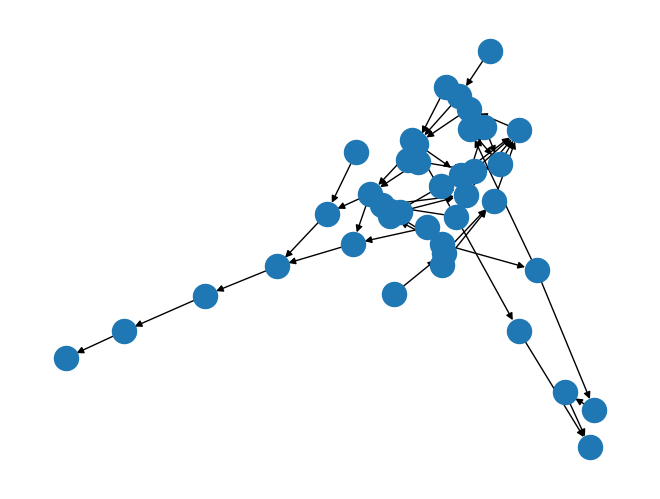

In [55]:
nx.draw(securization_flow)